Candidate Generation and LUNA prep by NrnavJain
In this dataset, you are given over a thousand low-dose CT images from high-risk patients in DICOM format. Each image contains a series with multiple axial slices of the chest cavity. Each image has a variable number of 2D slices, which can vary based on the machine taking the scan and patient. 
The DICOM files have a header that contains the necessary information about the patient id, as well as scan parameters such as the slice thickness.
The competition task is to create an automated method capable of determining whether or not the patient will be diagnosed with lung cancer within one year of the data the scan was taken.The ground truth labels were confirmed by pathology diagnosis. 
The images in this dataset come from many sources and will very in quality. For example, older scans were imaged with less sophisiticated equipment. You should expect the stage 2 data to be, on the whole, more recent and higher qualith than the stage 1 data (generally having thinner slice thickness). Ideally, your algorithm should perform well across a range of image quality. 

Notes

. Use of external data is permitted in this competition, provided the data is freely available. If you are using a source of external data, you must post the source to the official external data forum thread no later than one week prior to the deadline of the first stage. 
. This is a two-stage competition. In order to appear on the final competition leaderboard and receive ranking points, your team must make a submission during both stages of the competition. 

. Due to the large file size, Kaggle is beta testing use of BitTorrent as an alternate means of download. The image archives are cncrypted in order to prevent outside access. Please do nto share the decryption password. The large 1.7z archive hosted on BitTorrent is the same as the version available for direct download. 

File Descriptions

Each patient id has an associated disrectory of DICOM files. The patient id is found in the DICOM header and is identical to the patient name. The exact number of images will differ from case to case, varying according in the number of slices. Images were compressde as .7z files due to the large size of the dataset.

.stage1.7z -- contains all images for the first stage of the competition, including both the training and test set. This is file also hosted on BitTorrent. 

.stage1_label.csv -- contains the cancer ground truth for the stage 1 training set images. 

.stage1_sample_submission.csv -- shows the submission format for stage 1. You should also use this file to determine which patients belong to the leaderboard set of stage 1. 

.sample_images.7z -- a smaller subset of the full dataset, provided for people who wish to preview the images before downloading the large file. 

.data_password.txt -- contains the decryption key for the image files

The DICOM standard is complex and there are a number of different tools to work with DICOM files. You may find the following resources helpful for managing the competition data:

This tutorial aims to provide a comprehensive overview of useful steps to take before the data hits your ConvNet/other ML method. 

What we will cover:
> Loading the DICOM files, and adding missing metadata
> Converting the pixel values to Hounsfield Units (HU), and what tissue these unit values correspond to
> Resampling to an isomorphic resolution to remove variance in scanner resolution
> 3D plotting, visualization is very useful to see what we are doing
> Lung segmentation
> Normalization that makes sense
> Zero centering the scans

In [3]:
# Before we start, let's import some packages and determine the available patients.
%matplotlib inline 
# This turns on inline plotting, where plot graphics will appear in your notebook.
import numpy as np # Linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



In [7]:
# Some constants 
INPUT_FOLDER = 'sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

Dicom is the de-facto file standard in medical imaging. This is my first time working with it, but it seems to be fairly straightforward. These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world).
This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ), which can hurt performance of CNN approaches. We can deal with this by isomorphic resampling, which we will do later. 
Below is code to load a scan, which consists of multiple slices, which we simply save in a Python list. Every folder in the dataset in one scan (so one patient). One metadata field is missing, the pixel size in the Z direction, which is the slice thickness. Fortunately we can infer this, and we add this to the metadata. 


In [8]:
# Load the scans in given folder path

def load_scan(path):
    slices =[dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.
By default however, the returned values are not in this unit. 
Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently correspond to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

In [9]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16)
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
        
    return np.array(image, dtype=np.int16)  

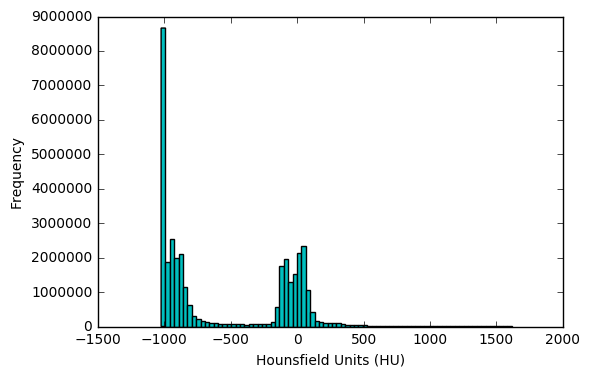

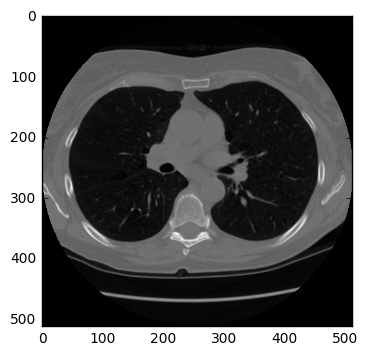

In [10]:
# Take a look at one of the patients.
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

Resampling
A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!
A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 
Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while. 
Below code worked well for us (and deals with the edge cases):

In [11]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [12]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


3D plotting the scan
For visualization it is useful to be able to show a 3D image of the scan. Unfortunately, the package available in this Kaggle docker image is very limited in this sense, so we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. Quit slow and ugly, but the best we can do. 

In [13]:
def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Fancy indexing: verts[faces] to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    plt.show()

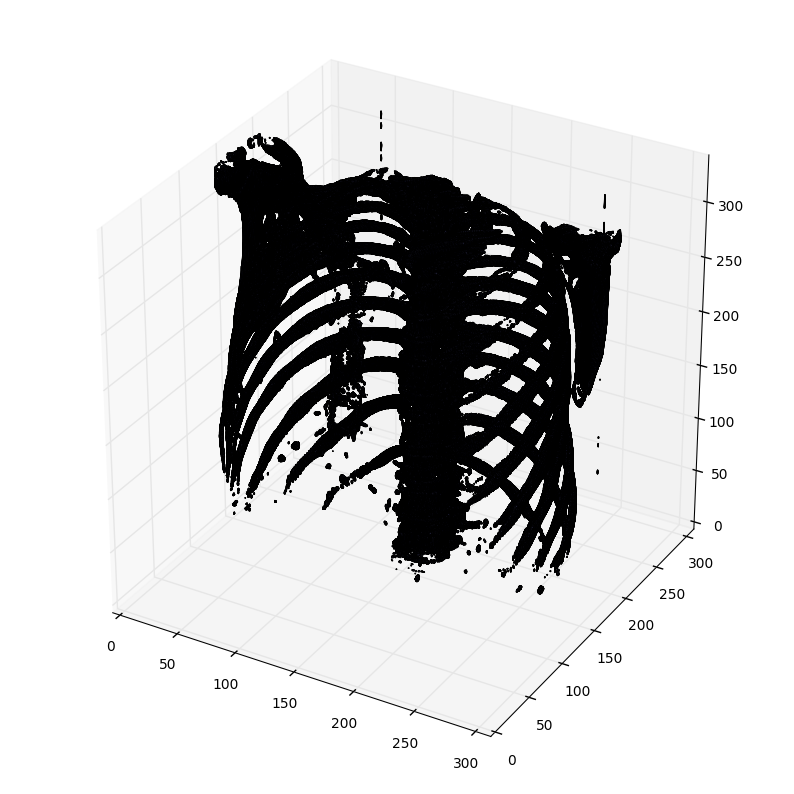

In [14]:
plot_3d(pix_resampled, 400)

Lung Segmentation
In order to reduce the problem space, we can segment the lungs (and usually some tissue around it). The method that me and my student colleagues developed was quite effective.
It involves quite a few smart steps. It consists of a series of applications of region growing and morphological operations. In this case, we will use only connected component analysis.
The steps:
> Threshold the image (-320HU is a good threshold, but it doesn't matter much for this approach)
> Do connected components, determine label of air around person, fill this with 1ss in the binary image
> Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
> Keep only the largest air pocket (the human body has other pockets of air here and there).

In [21]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually bianry, but 1 and 2.
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8) + 1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air. 
    # Improvement: Pick multile background lables from around the patient
    # More resistant to "trays" on which the patient lays cutting the air
    # around the person in half
    background_lable = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_lable == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
                
    binary_image -= 1 #Make the image actual binary
    binary_image = 1 - binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
        
    return binary_image
    
    

In [22]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

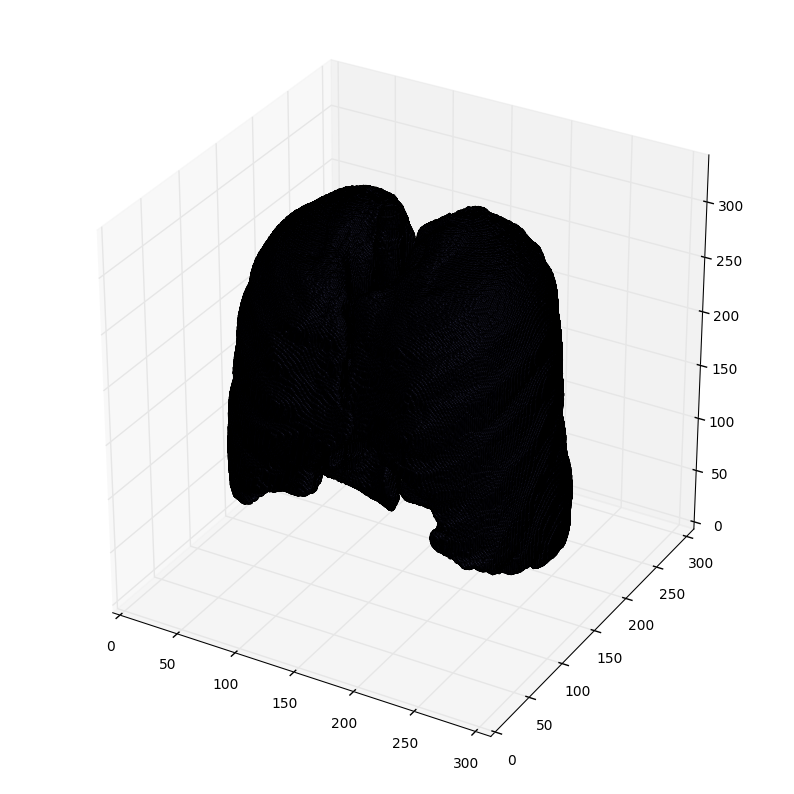

In [23]:
plot_3d(segmented_lungs, 0)

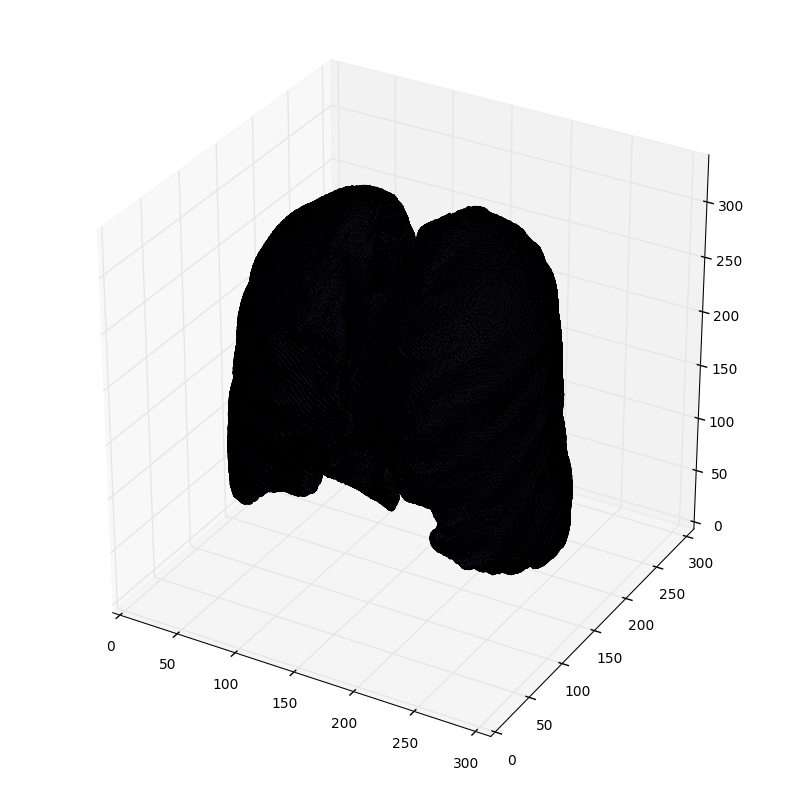

In [24]:
plot_3d(segmented_lungs_fill, 0)

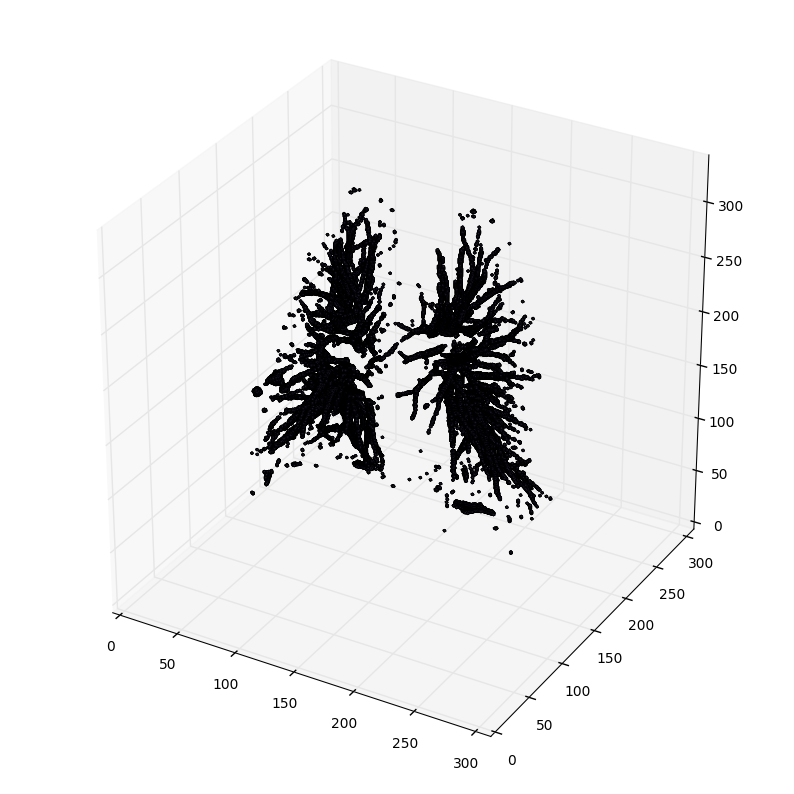

In [25]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

When you want to use this mask, remember to first apply a dilation morphological operation on it (i.e. with a circular kernel). This expands the mask in all directions. The air + structures in the lung alone will not contain all nodules, in particular it will miss those that are stuch to the side of the lung, where they often appear! So expand the mask a little. 
This segmentation may fail for some edge cases. It relies on the fact that the air outside the patient is not connected to the aid in the lungs. If the patient has a tracheostomy, this will not be the case, I do not know whether this is present in the dataset. Also, particulary noisy images (for instance due to a pacemaker in the image below) this method may also fail. Instead, the second largest air pocket in the body will be segmentded. You can then first apply a morphological closing operation with a kernel a few mm in size to close these holes, after which it should work (or more simply, do not use the mask for this image). 

Normalization
Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds in the LUNS16 competition to normalize between are -1000 and 400. Here's some code you can use:


In [26]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

Zero centering
As a final preprocessing step, it is advisory to zero center your data so that you mean value is 0. To do this you simply subtract the mean pixel value form all pixels. 
To determine this mean you simpy average all images in the whole dataset. If that sounds like a lot of work, we found this to be around 0.25 int LUNA16 competition.
Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures. 


In [27]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

What's next?

With these steps your images are ready for consumption by your CNN or other ML method. You can do all these steps offline (one time and save the result), and I would advise you to do so and let it run overnight as it may take a long time. 
Tip: To save storage spcae, don't do normalization and zero centering beforehand, but do this online (during training, just after loading). If you don't do this yet, your iamge are int16/s, which are smaller than float32s and easier to compress as well. 
